In [1]:
import argparse
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.eager import context

np.random.seed(555)

In [2]:
class FRNN(tf.keras.Model):
    
    def __init__(self, hidden_dim):
        super().__init__()
        self.lstm = tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=hidden_dim,
                                                      state_is_tuple=True)

    def call(self, input_seq):
        batch_size = input_seq.shape[1]
        state = self.lstm.zero_state(batch_size, tf.float32)

        X = tf.transpose(input_seq, [1, 0, 2])
        _, state = tf.compat.v1.nn.dynamic_rnn(self.lstm,
                                               X,
                                               initial_state=state)
        return state

In [3]:
class BRNN(tf.keras.Model):
    
    def __init__(self, hidden_dim, n_dim_obs=1, training=True):
        super().__init__()

        self.lstm = \
            tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=hidden_dim,
                                              state_is_tuple=True)

        self.out_linear = tf.keras.layers.Dense(
            n_dim_obs,
            kernel_initializer=tf.random_uniform_initializer(-0.1, 0.1))
 
        self.shape_linear = tf.keras.layers.Dense(
            hidden_dim,
            activation=tf.tanh,
            kernel_initializer=tf.random_uniform_initializer(-0.1, 0.1))
        self.n_dim_obs = n_dim_obs
        self.training = training

    def predict(self, state, seq_size):
        outputs = []
        output = self.out_linear(state[0])
        outputs.insert(0, output)
        for _ in range(1, seq_size):
            inp = self.shape_linear(output)
            _, state = self.lstm(inp, state)
            output = self.out_linear(state[0])
            outputs.insert(0, output)
        return outputs

    def train(self, input_seq, state, seq_size):
        outputs = []
        output = self.out_linear(state[0])
        outputs.insert(0, output)
        for t in reversed(range(1, seq_size)):
            inp = self.shape_linear(input_seq[t])
            out, state = self.lstm(inp, state)
            output = self.out_linear(state[0])
            outputs.insert(0, output)
        return outputs

    def call(self, f_lstm_latest_state, seq_size, input_seq=None):
        batch_size = f_lstm_latest_state[0].shape[0]
        self.lstm.zero_state(batch_size, tf.float32)

        state = f_lstm_latest_state[0]

        if self.training:
            outputs = self.train(input_seq, f_lstm_latest_state, seq_size)
        else:
            outputs = self.predict(f_lstm_latest_state, seq_size)
        return tf.stack(outputs, axis=0)


In [4]:
class EncDecAD(tf.keras.Model):

    def __init__(self,
                 hidden_dim,
                 n_dim_obs=1,
                 training=True):
        super().__init__()


        self.n_dim_obs = n_dim_obs
        self.f_lstm = FRNN(hidden_dim)
        self.b_lstm = BRNN(hidden_dim, n_dim_obs, training)
        self.trainig = training

    def reset(self, training):
        self.b_lstm.training = training

    def call(self, input_seq, training=True):
        self.reset(training)

        batch_size = input_seq.shape[1]
        seq_size = input_seq.shape[0]
        h = self.f_lstm(input_seq)
 
        outputs = self.b_lstm(h, seq_size, input_seq=input_seq)
        return outputs


In [5]:
def loss_fn(model, inputs, targets, training):
    seq_len, b_size, n_dim_obs = inputs.shape
    labels = tf.reshape(targets, [-1])
    outputs = model(inputs, training)

    individual_losses = tf.math.reduce_sum(
        tf.math.squared_difference(outputs, targets), axis=1)
    loss = tf.math.reduce_sum(individual_losses)
    return loss, outputs


In [6]:
def anomaly_score(outputs, targets, normal_data):
    seq_length, batch_size, n_dim_obs = targets.shape

    eval_residual = np.abs(outputs - targets)
    normal_residual = np.abs(outputs - normal_data)

    res_mu = normal_residual.mean(axis=(0,1))
    res_sig = normal_residual.std(axis=(0,1))
    res_sig_inv = np.linalg.pinv(res_sig) if res_sig.shape[0]>1 else 1/res_sig

    diff_mu = (eval_residual - res_mu).transpose(1,0,2).reshape(-1, n_dim_obs)
    if len(res_sig_inv)==1:
        scores = diff_mu / res_sig_inv * diff_mu
    else:
        scores = diff_mu.dot(res_sig_inv) * diff_mu
    return scores.sum(axis=1)

In [7]:
def _divide_into_batches(data, batch_size):
    n_time, n_dim_obs = data.shape
    nbatch = n_time // batch_size
    data = data[:nbatch * batch_size]
    data = data.reshape(batch_size, -1, n_dim_obs).transpose((1,0,2))
    return data

In [8]:
def _get_batch(data, i, seq_len):
    slen = min(seq_len, data.shape[0] - i)
    inputs = data[i:i + slen]
    target = inputs.copy()
    return tf.constant(inputs), tf.constant(target)


In [9]:
def evaluate(args, model, eval_data, train_data, training=False):
    total_loss = 0.0
    total_batches = 0
    start = time.time()
    l_scores = []
    for _, i in enumerate(range(0, eval_data.shape[0], args.seq_len)):
        # バッチ毎にデータを取得
        inp, target = _get_batch(eval_data, i, args.seq_len)
        # 損失計算
        loss, outputs = loss_fn(model, inp, target, training=training)
        total_loss += loss.numpy()
        total_batches += 1

        _, batch_size, _= inp.shape
        scores = anomaly_score(outputs, target, train_data[:, :batch_size])
        l_scores.append(scores)

    time_in_ms = (time.time() - start) * 1000
    sys.stderr.write("eval loss %.2f (eval took %d ms)\n" %
                   (total_loss / total_batches, time_in_ms))
    return total_loss, l_scores, outputs

In [10]:
def train(model, optimizer, train_data, sequence_length, clip_ratio,
          training=True):

    def model_loss(inputs, targets):
        return loss_fn(model, inputs, targets, training=training)[0]

    total_time = 0
    batch_start_idx_range = range(0, train_data.shape[0]-1, sequence_length)
    for batch, i in enumerate(batch_start_idx_range):
        train_seq, train_target = _get_batch(train_data, i, sequence_length)
        start = time.time()
        with tf.GradientTape() as tape:
            loss, _ = loss_fn(model, train_seq, train_target, training)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        total_time += (time.time() - start)
        if batch % 10 == 0:
            time_in_ms = (total_time * 1000) / (batch + 1)
            sys.stderr.write(
                "batch %d: training loss %.2f, avg step time %d ms\n" %
                    (batch, model_loss(train_seq, train_target).numpy(),
                     time_in_ms))


In [11]:
class Datasets(object):

    def __init__(self):
        t = np.linspace(0, 5*np.pi, 500)
        self.train = 10 * np.sin(t).reshape(-1,1)
        self.train = np.tile(np.abs(self.train), (32, 1)).astype('f')

        t = np.linspace(0, 4*np.pi, 400)
        self.valid = 10 * np.sin(t).reshape(-1,1)
        self.valid = np.concatenate(
            (np.random.randn(100).reshape(100,1), self.valid),
            axis=0)
        self.valid = np.tile(np.abs(self.valid), (4, 1)).astype('f')



In [14]:
import numpy as np

#np.array([[1,2,3],[4,5,6],[7,8,9]]).flatten()  

def main(args):
    if not args.data_path:
        raise ValueError("Must specify --data-path")
    data = Datasets()

    train_data = _divide_into_batches(data.train, args.batch_size)
    eval_data = _divide_into_batches(data.valid, args.eval_batch_size)
    
    plt.plot(train_data.flatten())
    plt.show()
    plt.plot(eval_data.flatten())
    plt.show()
    
    have_gpu = 0
    
    # デバイスの割り当て（GPUデバイスが検出されない場合は使わない）
    with tf.device("/device:GPU:0" if have_gpu else None):
        # 学習係数
        # 学習係数は変化するのでVariableで定義
        learning_rate = tf.Variable(args.learning_rate, name="learning_rate")
        sys.stderr.write("learning_rate=%f\n" % learning_rate.numpy())
        # EncDecADクラスのインスタンス作成
        model = EncDecAD(args.hidden_dim, args.training)
        # オプティマイザーオブジェクトの作成
        optimizer = tf.keras.optimizers.Adam(learning_rate)

        best_loss = None
        cnt = 0
        # エポック毎のループ
        for _ in range(args.epoch):
            # 訓練
            train(model, optimizer, train_data, args.seq_len, args.clip)
            # 評価
            eval_loss, l_scores, outputs = evaluate(args,
                                                    model,
                                                    eval_data,
                                                    train_data)
            # テストデータを使った評価での損失が下がった場合
            if not best_loss or eval_loss < best_loss:
                best_loss = eval_loss
                cnt = 0
            # テストデータを使った評価での損失が下がらなかった場合
            else:
                cnt += 1
                # 6回連続で下がらなかった場合
                if cnt>5:
                    # 学習係数を1/1.2倍する
                    learning_rate.assign(max(learning_rate/1.2, .002))
                    sys.stderr.write(
                        "eval_loss did not reduce in this epoch, "
                        "changing learning rate to %f for the next epoch\n" %
                            learning_rate.numpy())
                    cnt = 0

        scores = l_scores[0]
        for score in l_scores[1:]:
            scores = np.concatenate((scores, score))
        # 結果の表示
        plt.plot(data.train[:len(data.valid)],
                 color='g', alpha=0.5, label="normal")
        plt.plot(data.valid,
                 ':', color='b', alpha=0.5, label="anomalous")
        plt.plot(outputs.numpy().transpose(1,0,2).flatten(),
                 '--', color='y', label="predict")
        plt.plot(scores, '+-',  color='r', alpha=0.3, label="score")
        plt.show()


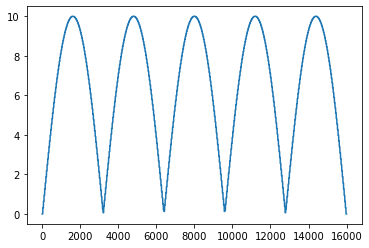

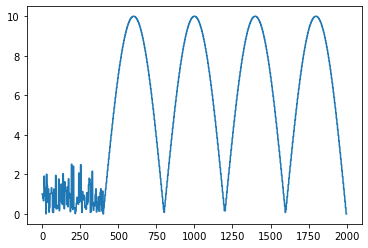

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


learning_rate=0.050000
C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
C:\Users\flare\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
batch 0: training loss 750009.88, avg step time 2618 ms
eval loss 78790.39 (eval took 981 ms)
batch 0: training loss 422371.03, avg step time 4221 ms
eval loss 60701.47 (eval took 886 ms)
batch 0: training loss 74232.21, avg step time 1987 ms
eval loss 31216.30 (eval took 921 m

eval loss 35727.92 (eval took 1028 ms)
batch 0: training loss 29165.90, avg step time 2411 ms
eval loss 36133.98 (eval took 1039 ms)
batch 0: training loss 28764.16, avg step time 3773 ms
eval loss 36705.40 (eval took 1399 ms)
batch 0: training loss 28368.06, avg step time 4319 ms
eval loss 37425.37 (eval took 1079 ms)
batch 0: training loss 27984.78, avg step time 2310 ms
eval loss 38269.54 (eval took 1813 ms)
eval_loss did not reduce in this epoch, changing learning rate to 0.006729 for the next epoch
batch 0: training loss 27679.09, avg step time 2354 ms
eval loss 39045.55 (eval took 1034 ms)
batch 0: training loss 27387.73, avg step time 2268 ms
eval loss 39862.70 (eval took 1077 ms)
batch 0: training loss 27110.85, avg step time 3278 ms
eval loss 40689.80 (eval took 1463 ms)
batch 0: training loss 26847.11, avg step time 2320 ms
eval loss 41494.53 (eval took 1083 ms)
batch 0: training loss 26594.12, avg step time 2376 ms
eval loss 42245.63 (eval took 1080 ms)
batch 0: training los

batch 0: training loss 21110.71, avg step time 9326 ms
eval loss 47509.35 (eval took 1629 ms)
eval_loss did not reduce in this epoch, changing learning rate to 0.002000 for the next epoch
batch 0: training loss 21066.97, avg step time 5493 ms
eval loss 47524.62 (eval took 1744 ms)
batch 0: training loss 21023.28, avg step time 3914 ms
eval loss 47539.43 (eval took 1372 ms)
batch 0: training loss 20979.66, avg step time 5359 ms
eval loss 47553.50 (eval took 1996 ms)
batch 0: training loss 20936.10, avg step time 3900 ms
eval loss 47566.57 (eval took 1474 ms)
batch 0: training loss 20892.61, avg step time 6263 ms
eval loss 47578.43 (eval took 1417 ms)
batch 0: training loss 20849.17, avg step time 4878 ms
eval loss 47588.97 (eval took 2983 ms)
eval_loss did not reduce in this epoch, changing learning rate to 0.002000 for the next epoch
batch 0: training loss 20805.79, avg step time 5104 ms
eval loss 47597.93 (eval took 3361 ms)
batch 0: training loss 20762.46, avg step time 5040 ms
eval 

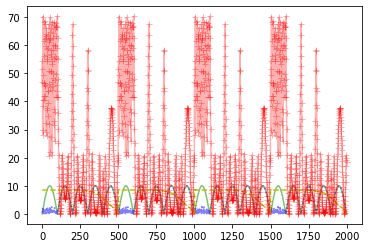

In [15]:
if __name__ == "__main__":
    
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--data-path",type=str,default="./")
    parser.add_argument("--learning-rate", type=float, default=.05, help="Learning rate.")
    parser.add_argument("--epoch", type=int, default=200, help="Number of epoches.")
    parser.add_argument("--batch-size", type=int, default=32, help="Batch size.")
    parser.add_argument("--eval-batch-size", type=int, default=4, help="Batch size.")
    parser.add_argument("--seq-len", type=int, default=500, help="Sequence length.")
    parser.add_argument("--hidden-dim", type=int, default=10, help="Hidden layer dimension.")
    parser.add_argument("--clip", type=float, default=0.3, help="Gradient clipping ratio.")
    parser.add_argument("--training", type=bool, default=True, help="Training or not.")
    
    args, unparsed = parser.parse_known_args()
    main(args)